In [1]:
from matplotlib import pyplot
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed

from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
# LOAD FACENET TRAINED NET
model = load_model('model/facenet_keras.h5', compile=False)
# input - color image 160 * 160 * 3
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


In [3]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    
    detector = MTCNN()
    
    # detect faces in the image
    results = detector.detect_faces(pixels)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    return asarray(image)


# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces


# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        if not isdir(path):
            continue
            
        faces = load_faces(path)
        # create labels - target
        labels = [subdir for _ in range(len(faces))]
        
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)


# get the face embedding for one face
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    
    # transform face into one sample
    # (160, 160, 3) -> (1, 160, 160, 3)
    samples = expand_dims(face_pixels, axis=0)

    yhat = model.predict(samples)
    return yhat[0]


def faces2embeddings(model, data):
    embeddings = list()
    for face_pixels in data:
        emb = get_embedding(model, face_pixels)
        embeddings.append(emb)
    return asarray(embeddings)

In [4]:
# GET TRAIN AND TEST DATA from dir
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)

testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)

# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 1 examples for class: ilya
>loaded 19 examples for class: madonna
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
(94, 160, 160, 3) (94,)
>loaded 5 examples for class: ben_afflek
>loaded 1 examples for class: ilya
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
(26, 160, 160, 3) (26,)


In [7]:
# load the face dataset from compressed data
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# convert each face in the train set to an embedding
embd_TrainX = faces2embeddings(model, trainX)

# convert each face in the test set to an embedding
embd_TestX = faces2embeddings(model, testX)

# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', embd_TrainX, trainy, embd_TestX, testy)

Loaded:  (94, 160, 160, 3) (94,) (26, 160, 160, 3) (26,)


In [9]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=94, test=26
Accuracy: train=100.000, test=96.154


[[0.02449558 0.02827813 0.01750985 0.00840275 0.02027269 0.901041  ]]
Predicted: mindy_kaling (90.104)
Expected: mindy_kaling


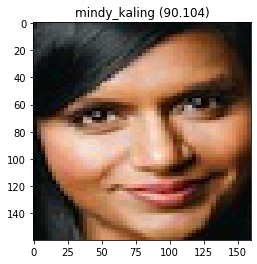

In [10]:
from random import choice
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
print(yhat_prob)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# 1- afflek, 2- elton john , 3 - ilya, 4 - seinfeild, 5- madonna, 6- mindy

pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
# DONT LOOK AT THIS!
def img_path_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    return img_to_encoding(img1, model)
    

def img_to_encoding(image, model):
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding